# landcover-hack ODC workshop 2019

This is a test notebook to derive a level 3 classification for select areas in Australia based on the FAO LCCS landcover classification

Before you run through - for now, pull down and checkout branch `odc-interface` from `git clone git@bitbucket.org:au-eoed/livingearth_lccs.git`

In [2]:
import numpy
import xarray
import scipy
from matplotlib import pyplot
import datacube
from datacube.storage import masking

In [3]:
# Need to point to the livingearth code for the classification module
import sys
sys.path.append("../livingearth_lccs")
from le_lccs.le_classification import lccs_l3

Data input from AWS DEA

In [6]:
# set up object and bounds

variables_xarray_list = []
dc = datacube.Datacube(app="le_lccs")

# Use 100 x 100 m to make it a bit easier - can change
pixel_size_x = 100
pixel_size_y = -100

min_x = 1500000.000
max_x = 1600000.000
min_y = -2200000.000
max_y = -2100000.000

out_crs = "EPSG:3577"

min_lon = 146.39916792060743
max_lon = 146.29233424663812
min_lat = -19.740788455284356
max_lat = -18.84675082028807

start_time = "2017-01-01"
end_time = "2018-01-15"

## 5 layers required for level 3 classification

- vegetat_veg_cat (layer for vegetation/non vegetation)
- aquatic_wat_cat (layer for aquatic/terrestrial
- cultman_agr_cat (layer for cultivated/natural)
- artific_urb_cat (layer for artificial surfaces/bare areas)
- artwatr_wat_cat (layer for artificial water/natural water)

### vegetat_veg_cat

In [7]:
var_xarray = dc.load(product="fc_percentile_albers_annual", measurements=["PV_PC_10", "NPV_PC_10"],
                     x=(min_x, max_x),
                     y=(min_y, max_y),
                     crs=out_crs,
                     resolution=(pixel_size_x, pixel_size_y),
                     time=(start_time, end_time))

# Check that dataset exists
var_xarray

<xarray.Dataset>
Dimensions:    (time: 1, x: 1000, y: 1000)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01
  * y          (y) float64 -2.2e+06 -2.2e+06 -2.2e+06 -2.2e+06 -2.2e+06 ...
  * x          (x) float64 1.6e+06 1.6e+06 1.6e+06 1.6e+06 1.6e+06 1.599e+06 ...
Data variables:
    PV_PC_10   (time, y, x) int16 36 59 60 32 51 59 57 70 36 30 74 27 50 63 ...
    NPV_PC_10  (time, y, x) int16 8 4 3 10 5 3 4 5 4 4 8 12 15 5 5 9 20 5 9 ...
Attributes:
    crs:      EPSG:3577

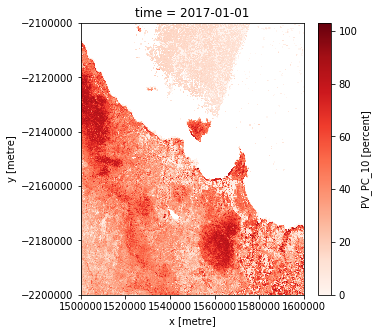

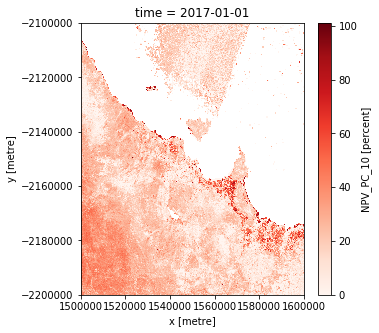

In [8]:
# Plot data
var_xarray = masking.mask_invalid_data(var_xarray)
var_xarray.PV_PC_10.plot(figsize=(5, 5), cmap = 'Reds')
var_xarray.NPV_PC_10.plot(figsize=(5, 5), cmap = 'Reds')

In [9]:
# Create binary layer representing vegetated (1) and non-vegetated (0)
vegetat_veg_cat_ds = ((var_xarray["PV_PC_10"] >= 1) | (var_xarray["NPV_PC_10"] >= 1))

In [10]:
# Convert to Dataset and add name
vegetat_veg_cat_ds = vegetat_veg_cat_ds.to_dataset(name="vegetat_veg_cat")

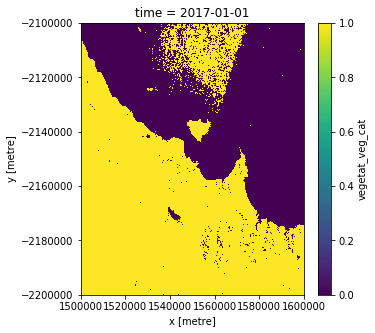

In [11]:
# Plot output
vegetat_veg_cat_ds["vegetat_veg_cat"].plot(figsize=(5, 5))

In [12]:
# Add to output array
variables_xarray_list.append(vegetat_veg_cat_ds)

### aquatic_wat_cat

In [13]:
var_xarray = dc.load(product="wofs_annual_summary",measurements=["count_wet"], 
                     x=(min_x, max_x),
                     y=(min_y, max_y),
                     crs=out_crs,
                     resolution=(pixel_size_x, pixel_size_y),
                     time=(start_time, end_time))

# Check that dataset exists
var_xarray

<xarray.Dataset>
Dimensions:    (time: 1, x: 1000, y: 1000)
Coordinates:
  * time       (time) datetime64[ns] 2017-01-01
  * y          (y) float64 -2.2e+06 -2.2e+06 -2.2e+06 -2.2e+06 -2.2e+06 ...
  * x          (x) float64 1.6e+06 1.6e+06 1.6e+06 1.6e+06 1.6e+06 1.599e+06 ...
Data variables:
    count_wet  (time, y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
Attributes:
    crs:      EPSG:3577

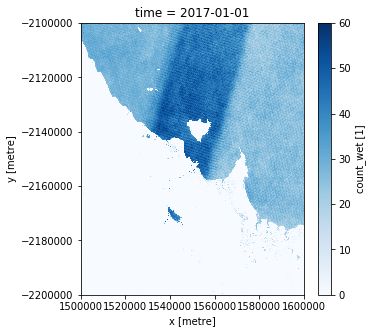

In [14]:
# Plot data
var_xarray = masking.mask_invalid_data(var_xarray)
var_xarray.count_wet.plot(figsize=(5, 5), cmap = 'Blues')

In [15]:
# Create binary layer representing aquatic (1) and terrestrial (0)
aquatic_wat_cat_ds = ((var_xarray["count_wet"] >= 10))

In [16]:
# Convert to Dataset and add name
aquatic_wat_cat_ds = aquatic_wat_cat_ds.to_dataset(name="aquatic_wat_cat")

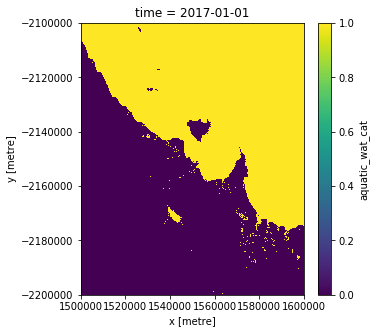

In [17]:
# Plot output
aquatic_wat_cat_ds["aquatic_wat_cat"].plot(figsize=(5, 5))

In [18]:
# Add to output array
variables_xarray_list.append(aquatic_wat_cat_ds)

### cultman_agr_cat

### artific_urb_cat

### artwatr_wat_cat

## Classification

The LCCS classificaition is hierachial. The 8 classes are shown below.

| Class name | Code | Numeric code |
|----------------------------------|-----|-----|
| Cultivated Terrestrial Vegetated | A11 | 111 |
| Natural Terrestrial Vegetated | A12 | 112 |
| Cultivated Aquatic Vegetated | A23 | 123 |
| Natural Aquatic Vegetated | A24 | 124 |
| Artificial Surface | B15 | 215 |
| Natural Surface | B16 | 216 |
| Artificial Water | B27 | 227 |
| Natural Water | B28 | 228 |


In [20]:
# Merge to a single dataframe
classification_data = xarray.merge(variables_xarray_list)

In [37]:
# Apply Level 3 classification using separate function. Works through in three stages
level1, level2, level3 = lccs_l3.classify_lccs_level3(classification_data)

In [57]:
# Save classification values back to xarray
out_class_xarray = xarray.Dataset({"level1" : (classification_data["vegetat_veg_cat"].dims, level1),
                                   "level2" : (classification_data["vegetat_veg_cat"].dims, level2),
                                   "level3" : (classification_data["vegetat_veg_cat"].dims, level3)})
classification_data = xarray.merge([classification_data, out_class_xarray])
classification_data

<xarray.Dataset>
Dimensions:          (time: 1, x: 1000, y: 1000)
Coordinates:
  * time             (time) datetime64[ns] 2017-01-01
  * x                (x) float64 1.6e+06 1.6e+06 1.6e+06 1.6e+06 1.6e+06 ...
  * y                (y) float64 -2.2e+06 -2.2e+06 -2.2e+06 -2.2e+06 ...
Data variables:
    vegetat_veg_cat  (time, y, x) bool True True True True True True True ...
    aquatic_wat_cat  (time, y, x) bool False False False False False False ...
    level1           (time, y, x) uint8 100 100 100 100 100 100 100 100 100 ...
    level2           (time, y, x) uint8 10 10 10 10 10 10 10 10 10 10 10 10 ...
    level3           (time, y, x) uint8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...